# MNIST Classification sing CNN




## Introduction
In this notebook, we will implement a Convolutional Neural Network (CNN) to classify images from the MNIST dataset.

The dataset consists of grayscale images of handwritten digits (0-9), each of size 28x28 pixels.

 We will use PyTorch to build, train, and evaluate our model.


### Import libraries

In [3]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, random_split

### Device

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Dataset & DataLoader

In [5]:
# Define transformations for the dataset
mean = (0.1307,)  
std  = (0.3081,)

transform = transforms.Compose([
    transforms.ToTensor(),                      
    transforms.Normalize(mean=mean, std=std)     
])

In [7]:
# Define a custom dataset class
class CustomMNISTDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

        self.classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]     
        if self.transform:
            img = self.transform(img)       
        return img, label

    def get_sample_from_class(self, label):
        for idx in np.random.permutation(len(self)):
            if self[idx][1] == label:
                return self[idx][0]

    def get_random_sample(self):
        idx = np.random.randint(len(self))
        return self[idx]

    def get_unNormalize(self, image, mean, std):
        # unnormalize the image to prepare it for visualization
        img = image.clone().cpu()
        for c, (m, s) in enumerate(zip(mean, std)):
            img[c] = img[c] * s + m
        np_img = img.numpy().squeeze() # because mnist is grayscale
        return np.clip(np_img, 0, 1)

    def get_interpolation(self, image1, image2, apha=0.5):
        return image1 * apha + image2 * (1-apha)

In [8]:
# Create Train, Validataion and Test set
raw_train = datasets.MNIST(root='./data', train=True,  download=True, transform=None)
raw_test  = datasets.MNIST(root='./data', train=False, download=True, transform=None)

val_size   = 10000
train_size = len(raw_train) - val_size  
train_subset, val_subset = random_split(raw_train, [train_size, val_size]) # splitting the dataset into train and validation

# here we use the same transformer for every dataset
custom_train = CustomMNISTDataset(dataset=train_subset, transform=transform)
custom_val   = CustomMNISTDataset(dataset=val_subset,   transform=transform)
custom_test  = CustomMNISTDataset(dataset=raw_test,     transform=transform)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.39MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [16]:
# Create Dataloaders
batch_size = 64
train_loader = DataLoader(custom_train, batch_size=batch_size, shuffle=True,  num_workers=1) # shuffle is requiered only for the train dataset 
val_loader   = DataLoader(custom_val,   batch_size=batch_size, shuffle=False, num_workers=1)
test_loader  = DataLoader(custom_test,  batch_size=batch_size, shuffle=False, num_workers=1)

### Visualization
Visualize 5 random images from each class using `plt.subplots`

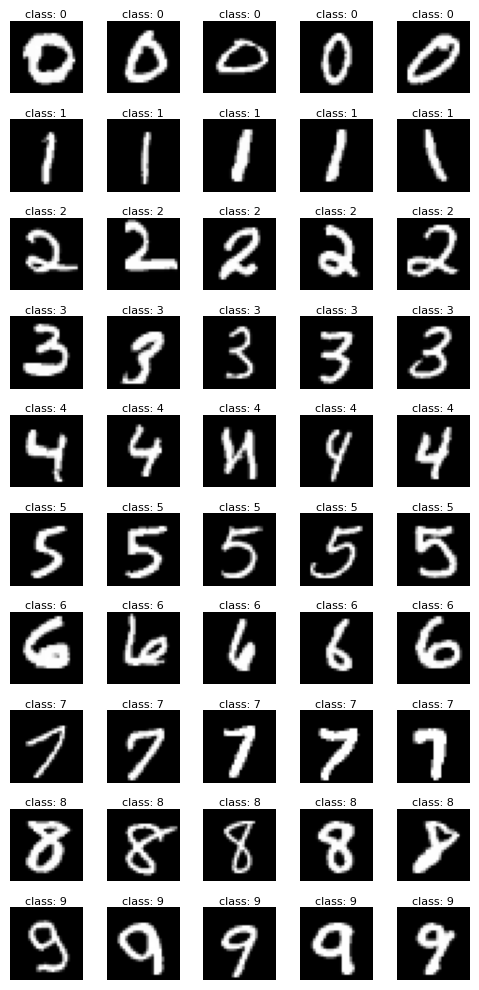

In [17]:
num_classes = 10
samples_per_class = 5

fig, axes = plt.subplots(num_classes, samples_per_class, 
                         figsize=(samples_per_class, num_classes))

for row in range(num_classes):
    for col in range(samples_per_class):
        img_t = custom_train.get_sample_from_class(row)       
        np_img = custom_train.get_unNormalize(img_t, mean, std)
        
        ax = axes[row, col]
        ax.imshow(np_img, cmap='gray')
        ax.axis('off')
        # add class label on top of each image
        ax.set_title(f"class: {row}", fontsize=8, pad=2)

plt.tight_layout()
plt.show()

Visualize interpolation between random image pairs

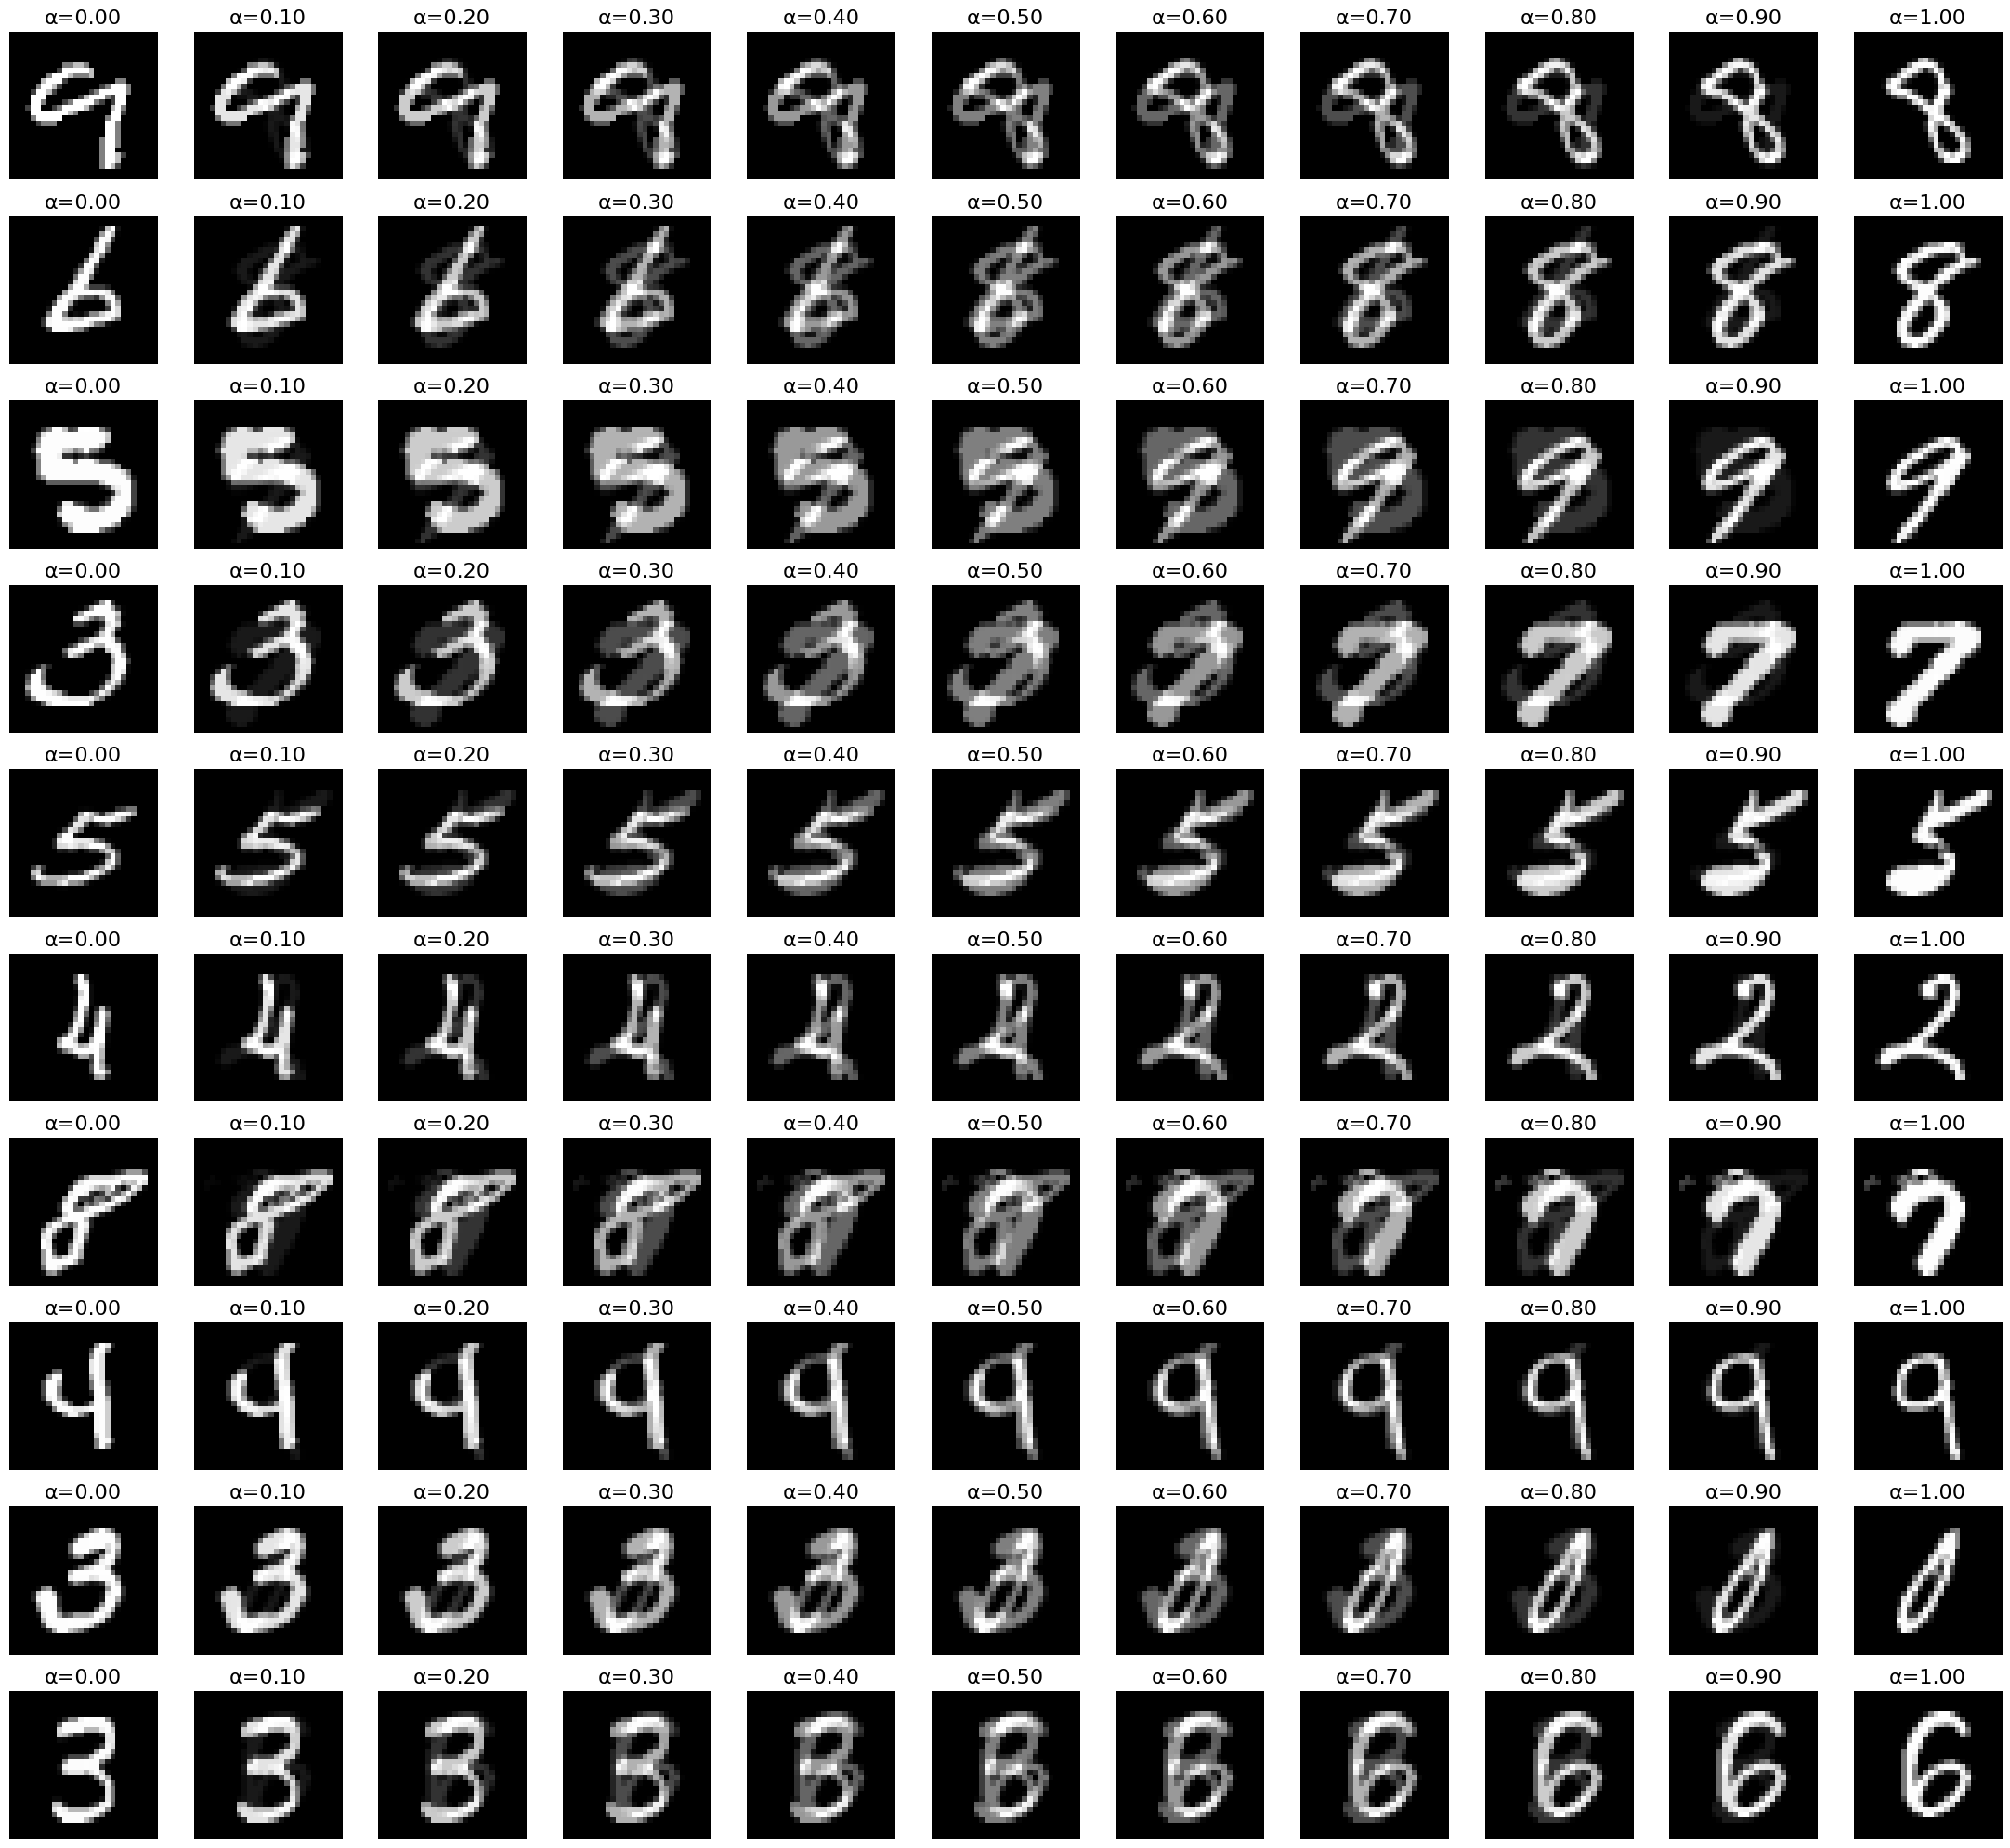

In [18]:
num_pairs = 10
num_interpolations = 11
mean = [0.1307]
std = [0.3081]

fig, axes = plt.subplots(num_pairs, num_interpolations,
                         figsize=(num_interpolations * 2, num_pairs * 2))

for row in range(num_pairs):
    img1, label1 = custom_train.get_random_sample()
    img2, label2 = custom_train.get_random_sample()
    
    for col, alpha in enumerate(np.linspace(0, 1, num_interpolations)):
        interpolated_img = custom_train.get_interpolation(img1, img2, alpha)
        np_img = custom_train.get_unNormalize(interpolated_img, mean, std)

        ax = axes[row, col]
        ax.imshow(np_img, cmap='gray')
        ax.axis('off')
        ax.set_title(f"α={alpha:.2f}", fontsize=16)

plt.tight_layout()
plt.show()

## Model


Define ResNet18 model from scratch

### ResNet Block

In [19]:
class ResNetBlock(torch.nn.Module):
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

### ResNet18

In [20]:
class ResNet18(torch.nn.Module):
    def __init__(self, block, num_classes, layers=[1, 1, 1, 1]):
        self.in_channels = 64
        in_dim = 1

        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)        
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
   
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
    
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, planes, stride, downsample))
        self.in_channels = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_channels, planes))

        return nn.Sequential(*layers)

    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = torch.nn.functional.softmax(logits, dim=1)
        return logits, probas


## Train

### Model instantiation
Create model and move it to device

In [21]:
model = ResNet18(block=ResNetBlock, num_classes=10)
model.to(device)

ResNet18(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

### Criterion, Optimizer and Scheduler
Define criterion and optimizer and scheduler

In [22]:
# cross entropy is the natural choice for multi-classification problems
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters()) 
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

### Train loop
Train your model and print epoch number, loss and accuracy for train and validation set and save them for later usage

In [23]:
import time

num_epochs = 10

def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [24]:
history = []

start_time = time.time()
for epoch in range(num_epochs):

    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, num_epochs))
    
    model.train()

    train_loss = 0.0
    train_acc = 0.0

    valid_loss = 0.0
    valid_acc = 0.0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):

        # everything shall be on the same device: cuda!
        inputs = inputs.to(device)
        labels = labels.to(device)
            
        # forward and backpropagation
        logits, probas = model(inputs)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        
        loss.backward()
        
        # update model parameters
        optimizer.step()

        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * inputs.size(0)

        # Compute the accuracy
        ret, predictions = torch.max(logits.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))

        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))

        # Compute total accuracy in the whole batch and add to train_acc
        train_acc += acc.item() * inputs.size(0)

    model.eval()
    with torch.set_grad_enabled(False):
        # Validation loop
        for j, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward pass
            logits, probas = model(inputs)

            # Compute loss
            loss = criterion(logits, labels)

            # update the valid_loss
            valid_loss += loss.item() * inputs.size(0)

            # calculate validation accuracy
            ret, predictions = torch.max(logits.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            valid_acc += acc.item() * inputs.size(0)

        # find average training loss and training accuracy
        avg_train_loss = train_loss / len(custom_train)
        avg_train_acc = train_acc / len(custom_train)

        # find average validation loss and accuracy
        avg_valid_loss = valid_loss / len(custom_val)
        avg_valid_acc = valid_acc / len(custom_val)

        epoch_end = time.time()

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
        
    print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

Epoch: 1/10
Epoch : 001, Training: Loss: 0.1188, Accuracy: 96.3700%, 
		Validation : Loss : 0.0756, Accuracy: 97.6500%, Time: 15.0596s
Epoch: 2/10
Epoch : 002, Training: Loss: 0.0566, Accuracy: 98.2980%, 
		Validation : Loss : 0.0568, Accuracy: 98.2400%, Time: 13.3575s
Epoch: 3/10
Epoch : 003, Training: Loss: 0.0429, Accuracy: 98.6860%, 
		Validation : Loss : 0.0657, Accuracy: 98.2500%, Time: 14.0890s
Epoch: 4/10
Epoch : 004, Training: Loss: 0.0357, Accuracy: 98.8940%, 
		Validation : Loss : 0.0503, Accuracy: 98.6100%, Time: 13.2574s
Epoch: 5/10
Epoch : 005, Training: Loss: 0.0301, Accuracy: 99.0160%, 
		Validation : Loss : 0.0398, Accuracy: 98.8800%, Time: 13.2919s
Epoch: 6/10
Epoch : 006, Training: Loss: 0.0265, Accuracy: 99.1820%, 
		Validation : Loss : 0.0410, Accuracy: 98.8600%, Time: 13.8101s
Epoch: 7/10
Epoch : 007, Training: Loss: 0.0249, Accuracy: 99.2280%, 
		Validation : Loss : 0.0477, Accuracy: 98.7400%, Time: 13.5738s
Epoch: 8/10
Epoch : 008, Training: Loss: 0.0221, Accura

### Visualize loss & Accuracy

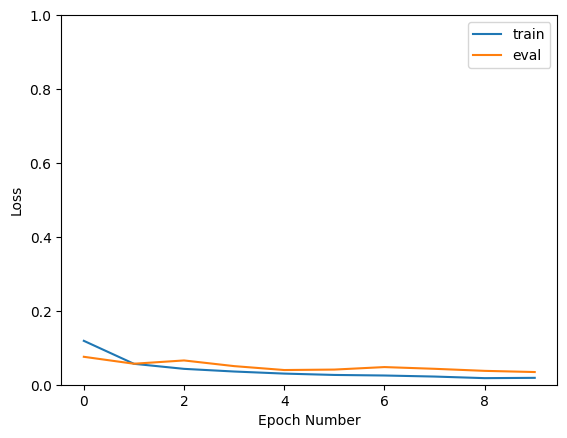

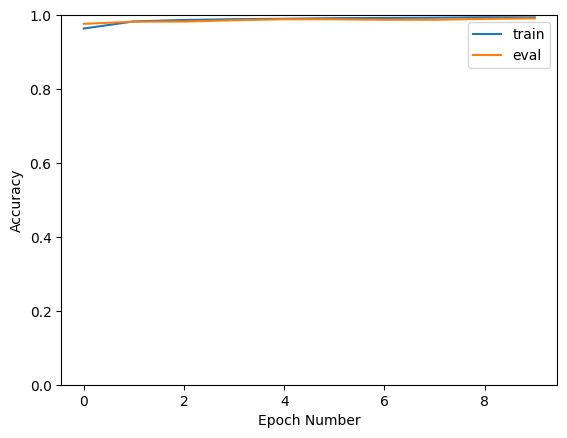

In [25]:
# as we expect, the train loss is initially larger than the validation loss
# but after some epochs, the model learns the training dataset.
# it looks like this model is really powerful for this classification
# and learns the features really fast. high test accuracy confirms this statement

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['train', 'eval'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()

plt.plot(history[:,2:4])
plt.legend(['train', 'eval'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

## Evaluation
Test you trained model using Test set. An accuracy above `95%` is acceptable.

In [29]:
with torch.no_grad(): 
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=device)))


Test accuracy: 99.12%


### Visualize incorrect predictions
Visualize some random images from testset that are incorrectly predicted by the model

In [36]:
wrong_imgs, wrong_labels, wrong_preds = [], [], []


model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, _ = model(inputs)
        preds   = outputs.argmax(dim=1)

        for img, true_lbl, pred_lbl in zip(inputs, labels, preds):
            img_cpu = img.cpu()
            t = true_lbl.cpu().item()
            p = pred_lbl.cpu().item()

            if p != t:
                wrong_imgs.append(img_cpu)
                wrong_labels.append(t)
                wrong_preds.append(p)
                

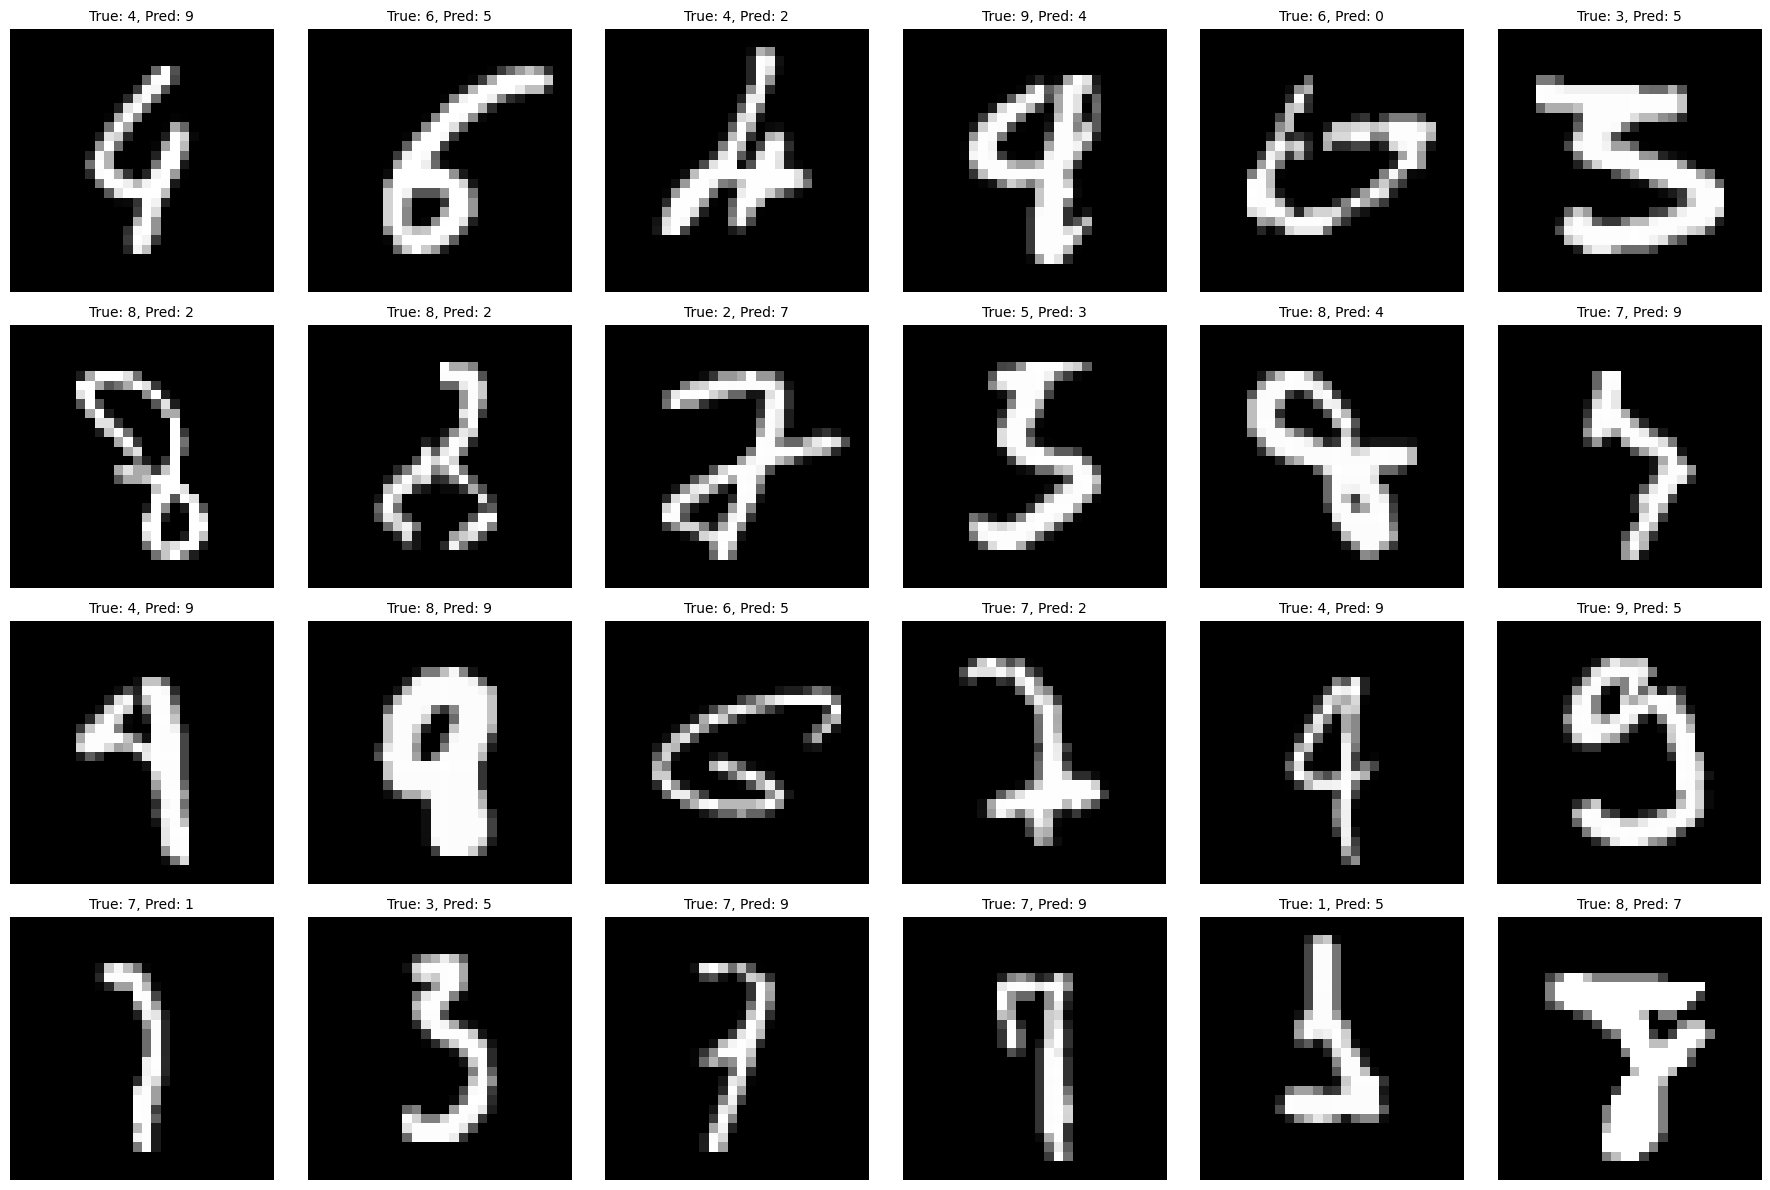

In [37]:
# looking at the wrong predicted images, it seems that some of these data are even hard for a human to classify
# most of them are written in a way that can be interpreted simultaneously as different digits by the model

num_to_show = 24
num_available = len(wrong_imgs)
if num_available < num_to_show:
    print(f"Only {num_available} misclassified images—showing those.")
    num_to_show = num_available

fig, axes = plt.subplots(4, 6, figsize=(18,12))
axes = axes.flatten()

for i in range(num_to_show):
    img = custom_train.get_unNormalize(wrong_imgs[i], mean, std)
    true_lbl = wrong_labels[i]
    pred_lbl = wrong_preds[i]

    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"True: {true_lbl}, Pred: {pred_lbl}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Interpolating transitions and model prediction
<ol>
<li>
Generate 10 random pairs of images without the same labels.
</li>

<li>
Interpolate between each pair from 0 to 1 in 0.1 steps and plot the results.
</li>

<li>
Use a model to calculate its confidence for each class.
</li>

</ol>

In [33]:
def sample_random_pairs(dataset, num_pairs=10):
    # flatten dataset into list of (img, label)
    imgs, labels = [], []
    for x, y in dataset:
        imgs.append(x)
        labels.append(y)
    imgs = torch.stack(imgs)
    labels = torch.tensor(labels)
    
    pairs = []
    N = len(labels)
    while len(pairs) < num_pairs:
        i, j = np.random.randint(0, N, size=2)
        if labels[i] != labels[j]:
            pairs.append((imgs[i], labels[i].item(), imgs[j], labels[j].item()))
    return pairs

def interpolate_and_predict(model, img1, img2, alphas):
    model.eval()
    probs = []
    with torch.no_grad():
        for alpha in alphas:
            x = (1-alpha)*img1 + alpha*img2
            x = x.unsqueeze(0).to(device)
            _, p = model(x)           
            probs.append(p.cpu().squeeze(0).numpy())
    return np.stack(probs, axis=0)

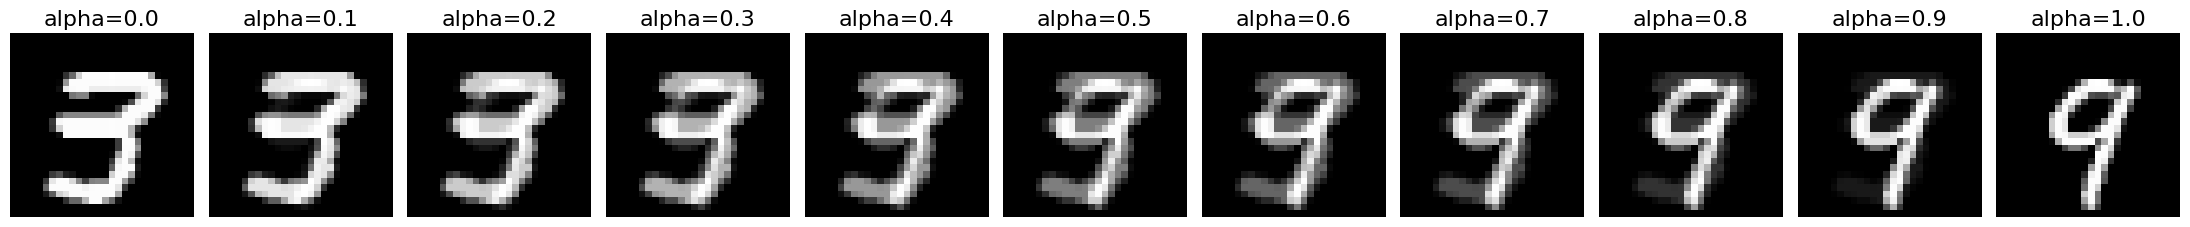

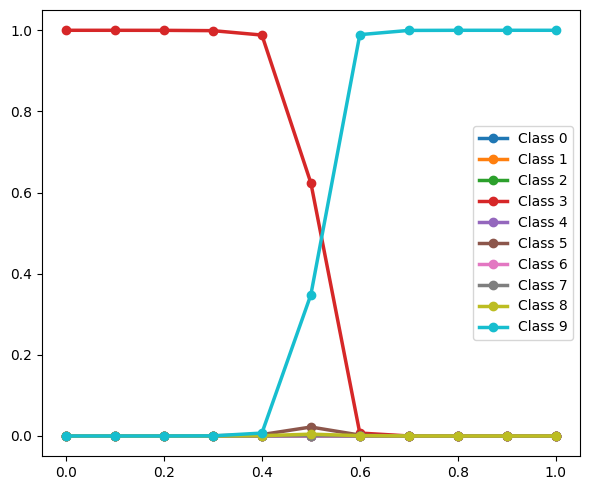

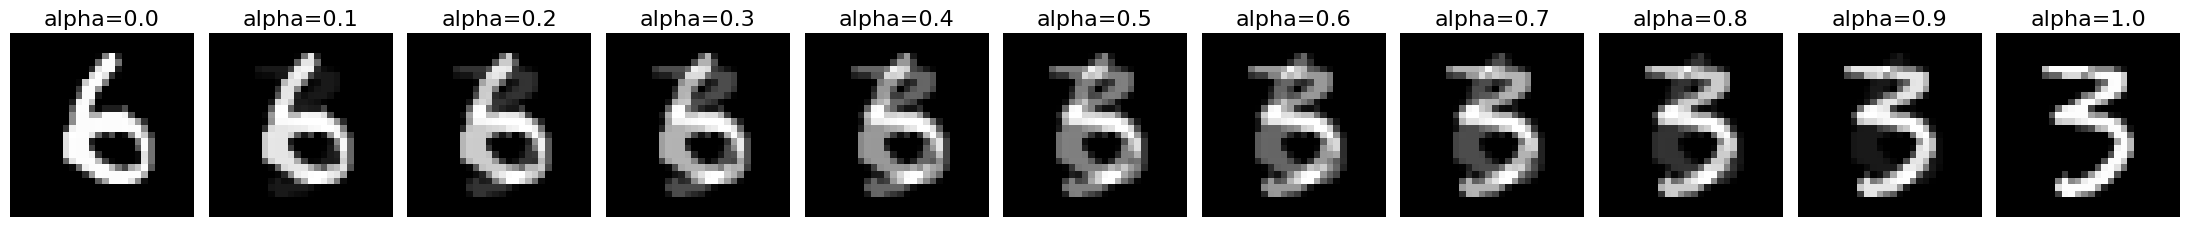

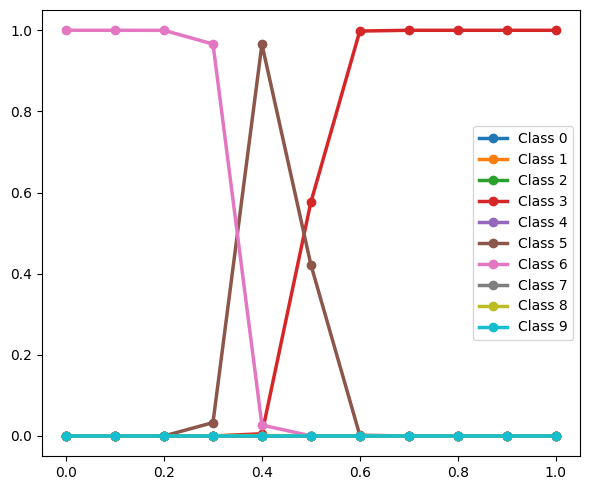

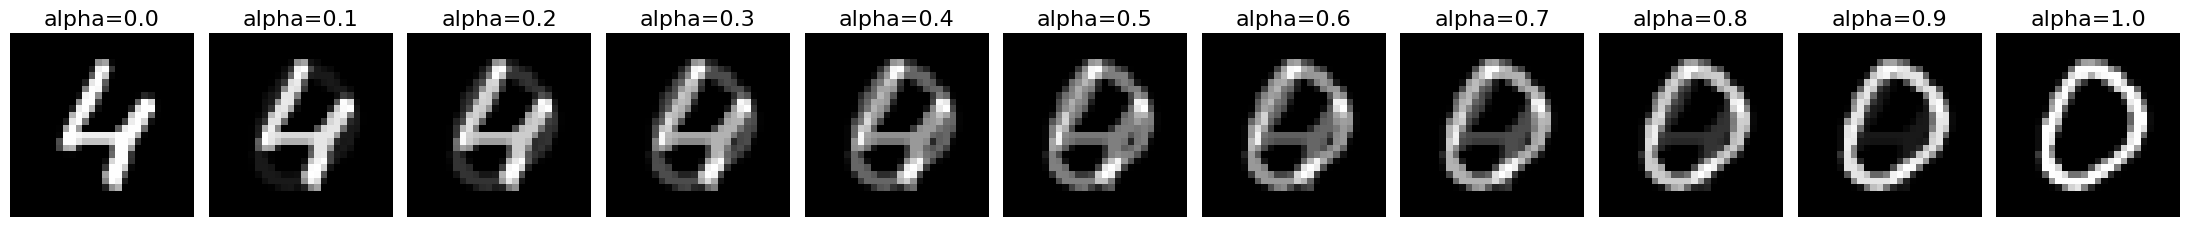

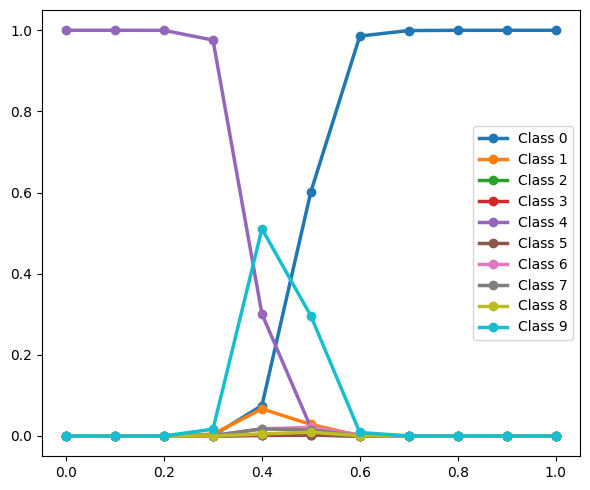

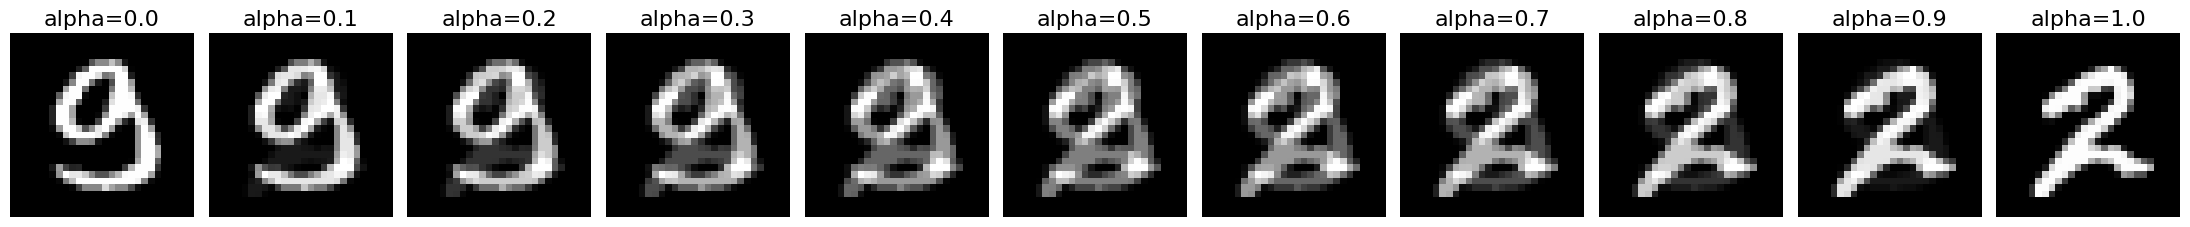

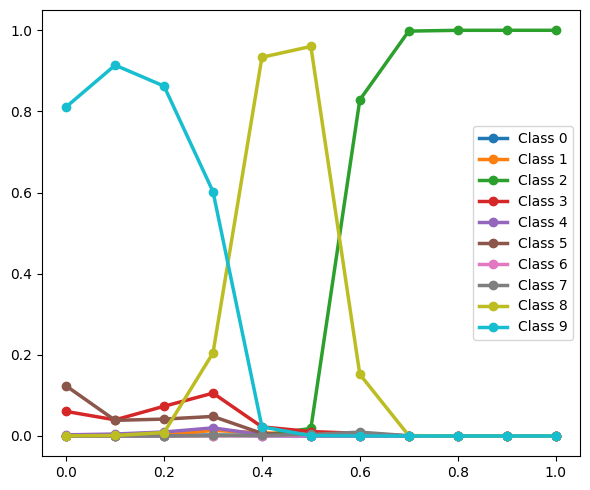

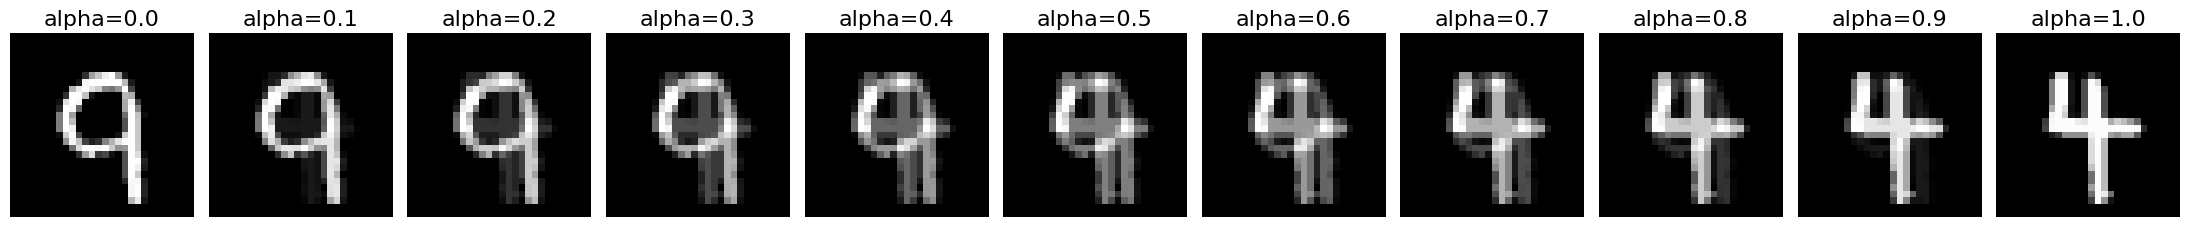

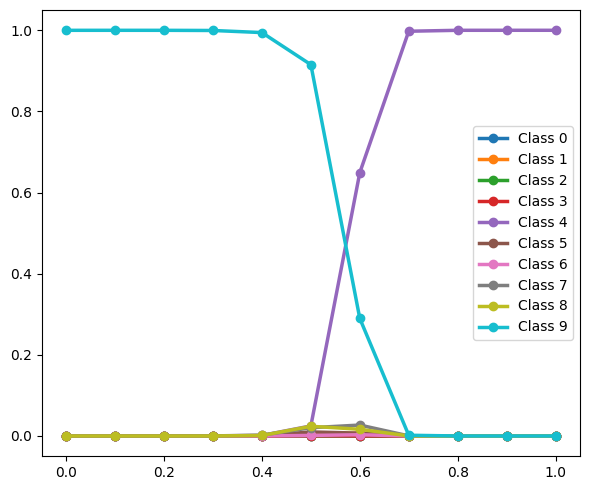

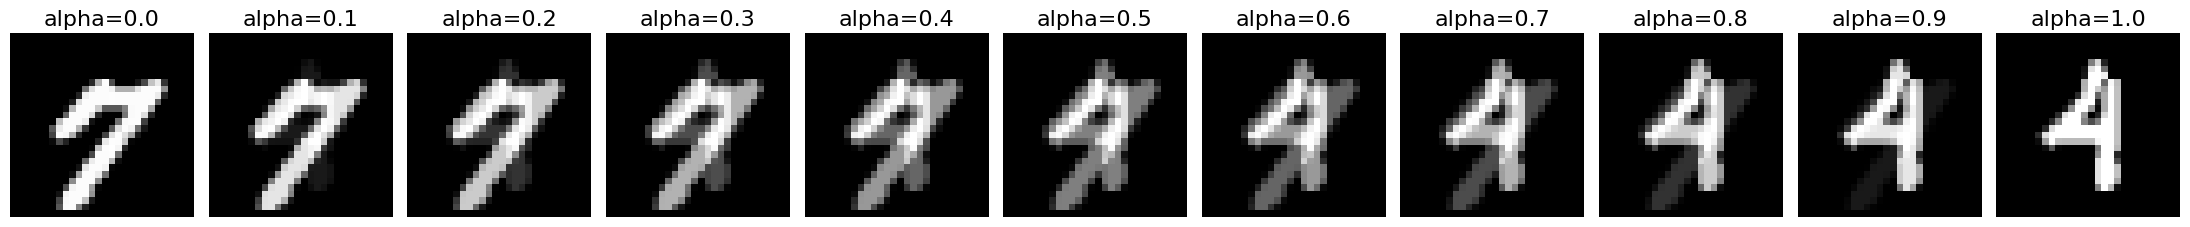

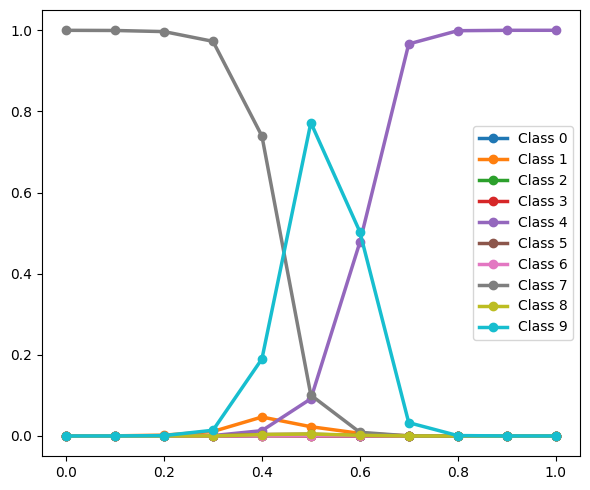

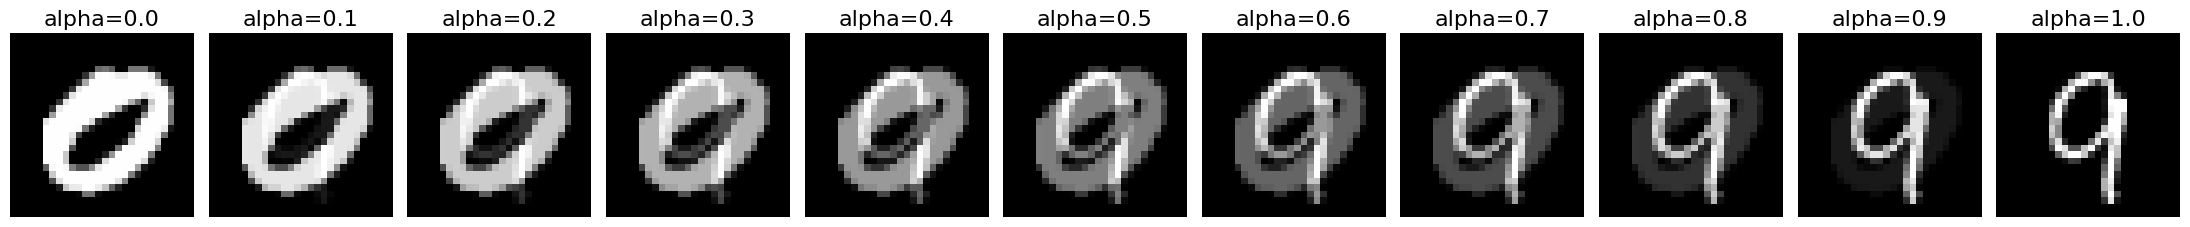

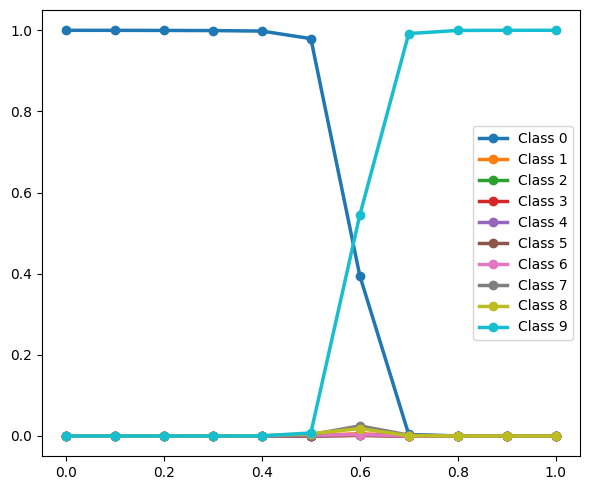

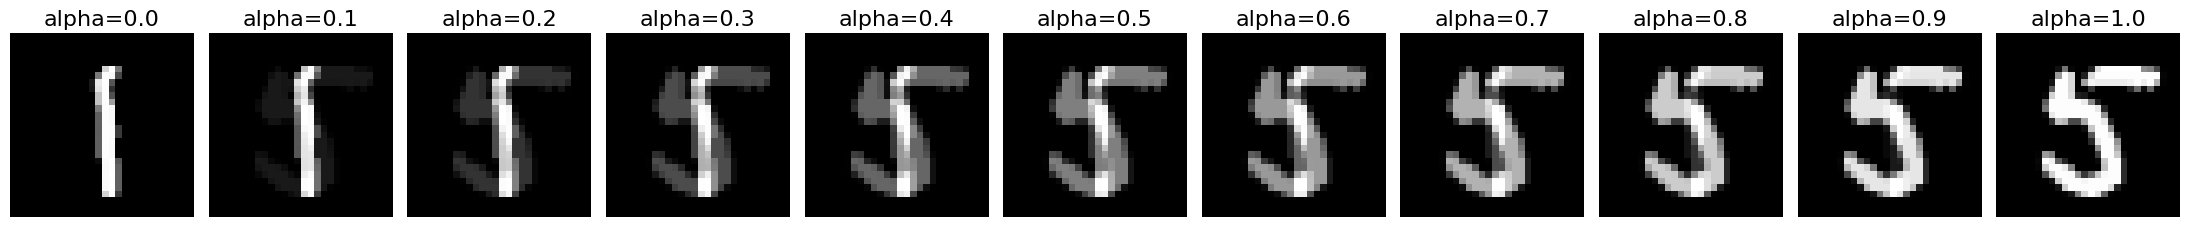

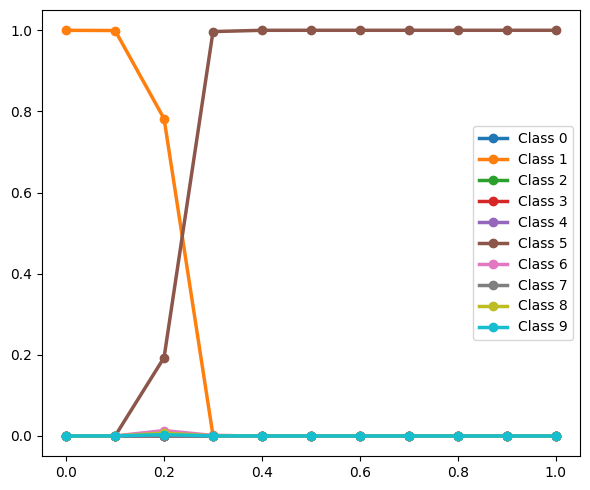

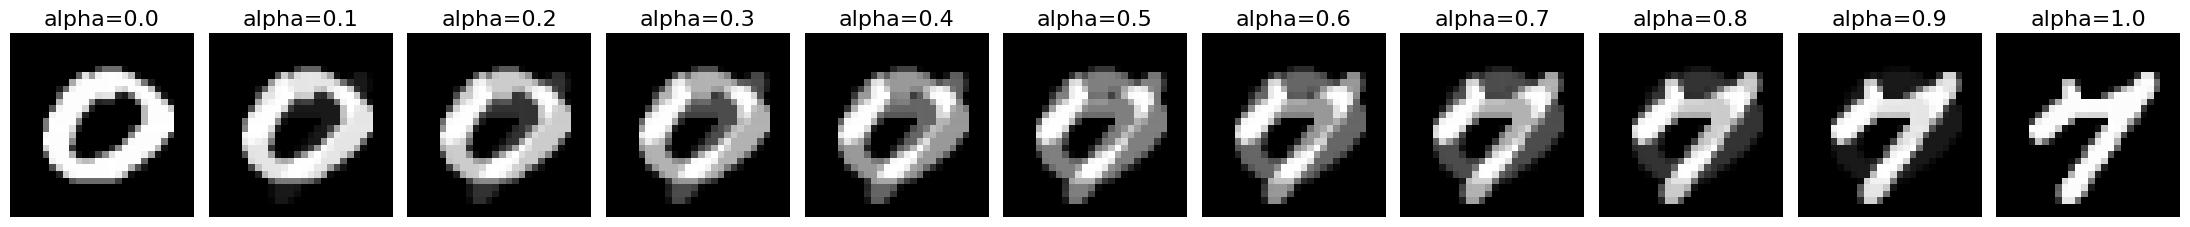

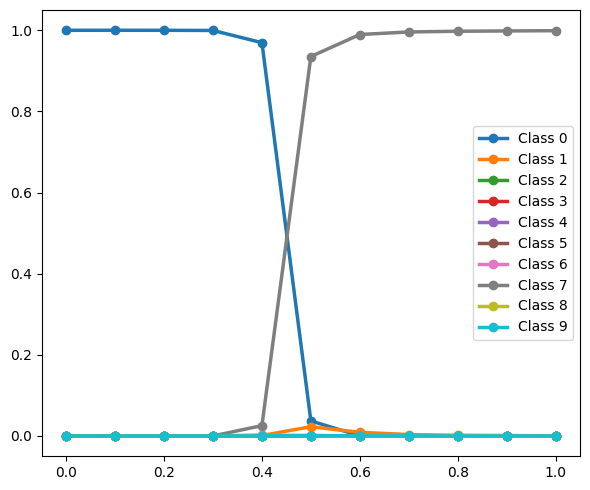

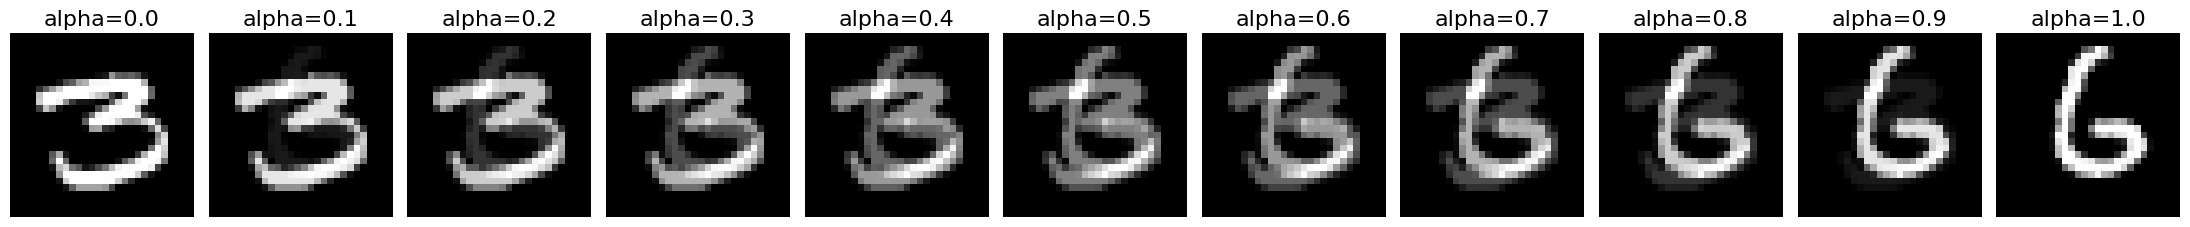

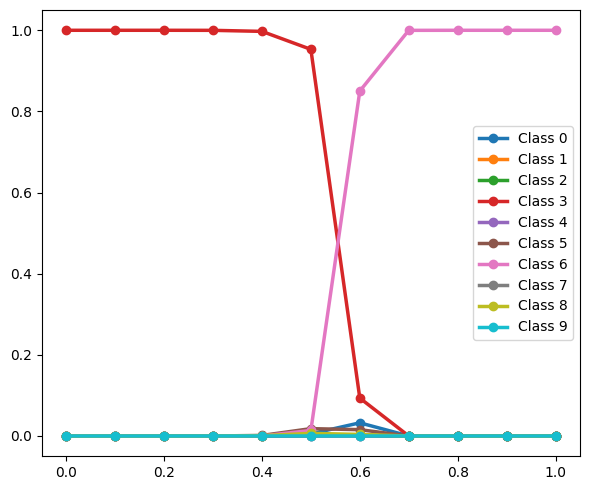

In [38]:
# these plots greatly reflect the feature extraction of the model.
# as alpha is changed, the features of one digit start to diminish leading to lower
# probability of that digit. at the same time, the features of the other digit become more
# and more apparent, leading to the shift to predict this later one. 
# in some rare cases, when alpha is around 0.5, the model can detect features
# related to several digits, leading to the model predicting neither of them



pairs = sample_random_pairs(test_loader.dataset)
alphas = np.linspace(0, 1, 11)

for idx, (img1, y1, img2, y2) in enumerate(pairs):
    confs = interpolate_and_predict(model, img1, img2, alphas)
    num_alphas = len(alphas)

    fig_imgs = plt.figure(figsize=(2 * num_alphas, 2.5))
    for k, alpha in enumerate(alphas):
        interp = (1 - alpha) * img1 + alpha * img2
        np_img = interp.permute(1, 2, 0).cpu().numpy()

        ax_img = fig_imgs.add_subplot(1, num_alphas, k + 1)
        ax_img.imshow(np_img.squeeze(), cmap='gray')
        ax_img.axis("off")
        ax_img.set_title(f"alpha={alpha:.1f}", fontsize=16)

    plt.tight_layout()
    plt.show()

    fig_conf = plt.figure(figsize=(6, 5))
    ax_conf = fig_conf.add_subplot(111)
    num_classes = confs.shape[1]

    for c in range(num_classes):
        ax_conf.plot(alphas, confs[:, c], marker='o', linewidth=2.5, label=f'Class {c}')

    ax_conf.legend(fontsize=10)

    plt.tight_layout()
    plt.show()
